In [9]:
import sys

PWD = '../../..'
sys.path.append(PWD)

import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

from src.cfd import CFD
from src.gauss_hist import get_gauss_stats
from src.network_utils import plot_difference_hist, compare_results

In [10]:
N_JOBS = 8

DATASET_PATH = '../../../data/dataset/dataset.pkl'

PRINT_PCOV = False

N_BASELINE = 8

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = '../../../data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42

In [11]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

In [12]:
x_time = np.arange(0, 24 / 7.695, 1 / 7.695)
x_time.shape

(24,)

# Utils

In [13]:
model_name = 'UNet'

def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x

def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x

def create_model():
    inputs = layers.Input(24)
    x = layers.Reshape((-1, 1))(inputs)

    skip1, x = conv_block(x, 64)
    skip2, x = conv_block(x, 128)
    skip3, x = conv_block(x, 256)
    x, _ = conv_block(x, 512)

    x = deconv_block(x, skip3, 256)
    x = deconv_block(x, skip2, 128)
    x = deconv_block(x, skip1, 64)

    x = layers.Conv1D(1, 1, activation='linear')(x)

    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model

def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(np.arange(24), y, a_0=1, std_0=1.)

    return y_pred

In [14]:
def load_model(model, name, path_component='many_channels_tests/trained_separately', root='..'):
    model.load_weights(f'{root}/model_weights/{path_component}/{name}/weights')
    history = pd.read_csv(f'{root}/model_weights/{path_component}/{name}/loss_log.csv')

    return history

# Load optimal CFD thresholds

In [15]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.170
(1, 11): 0.175
(2,  2): 0.230
(2, 11): 0.145
(3,  2): 0.140
(3, 11): 0.165


# Test

Processing p=1, ch=2...
2/2 [==============================] - 0s 238ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 75.42 ps
      UNet: 68.64 ps (improvement: 8.98 %)
Processing p=1, ch=11...
4/4 [==============================] - 0s 94ms/step
       CFD: 87.28 ps
      UNet: 84.28 ps (improvement: 3.43 %)
Processing p=2, ch=2...
2/2 [==============================] - 0s 55ms/step
       CFD: 78.14 ps
      UNet: 71.69 ps (improvement: 8.25 %)
Processing p=2, ch=11...
4/4 [==============================] - 0s 114ms/step
       CFD: 89.47 ps
      UNet: 90.94 ps (improvement: -1.64 %)
Processing p=3, ch=2...
2/2 [==============================] - 0s 99ms/step
       CFD: 87.37 ps
      UNet: 83.25 ps (improvement: 4.72 %)
Processing p=3, ch=11...
4/4 [==============================] - 0s 79ms/step
       CFD: 112.05 ps
      UNet: 160.24 ps (improvement: -43.01 %)


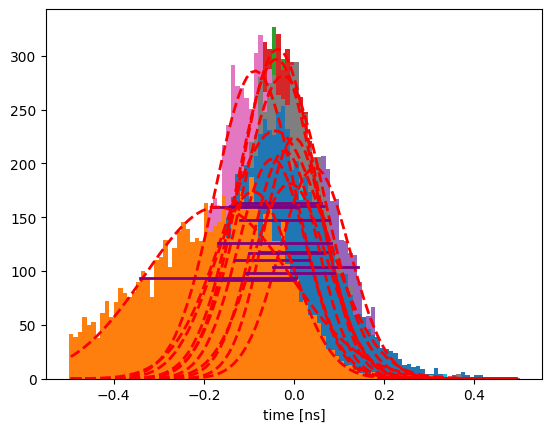

Processing p=1, ch=2...
2/2 [==============================] - 0s 79ms/step
       CFD: 75.42 ps
      UNet: 70.26 ps (improvement: 6.84 %)
Processing p=1, ch=11...
4/4 [==============================] - 0s 80ms/step
       CFD: 87.28 ps
      UNet: 79.45 ps (improvement: 8.97 %)
Processing p=2, ch=2...
2/2 [==============================] - 0s 42ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 78.14 ps
      UNet: 70.86 ps (improvement: 9.32 %)
Processing p=2, ch=11...
4/4 [==============================] - 0s 100ms/step
       CFD: 89.47 ps
      UNet: 84.28 ps (improvement: 5.80 %)
Processing p=3, ch=2...
2/2 [==============================] - 0s 122ms/step
       CFD: 87.37 ps
      UNet: 87.83 ps (improvement: -0.52 %)
Processing p=3, ch=11...
4/4 [==============================] - 0s 12ms/step
       CFD: 112.05 ps
      UNet: 154.77 ps (improvement: -38.13 %)


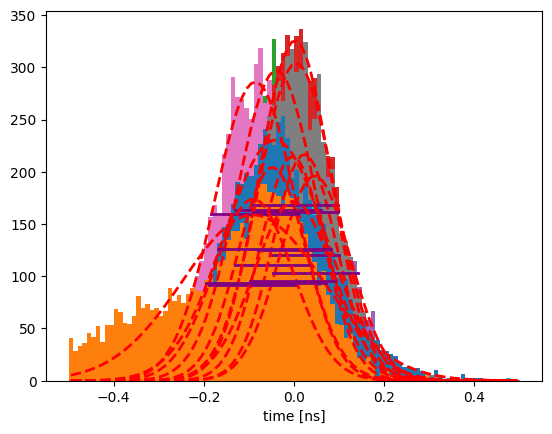

Processing p=1, ch=2...
2/2 [==============================] - 1s 291ms/step
       CFD: 75.42 ps
      UNet: 71.55 ps (improvement: 5.12 %)
Processing p=1, ch=11...
4/4 [==============================] - 0s 12ms/step
       CFD: 87.28 ps
      UNet: 83.12 ps (improvement: 4.77 %)
Processing p=2, ch=2...
2/2 [==============================] - 0s 102ms/step
       CFD: 78.14 ps
      UNet: 68.33 ps (improvement: 12.56 %)
Processing p=2, ch=11...
4/4 [==============================] - 0s 12ms/step
       CFD: 89.47 ps
      UNet: 86.05 ps (improvement: 3.82 %)
Processing p=3, ch=2...
2/2 [==============================] - 0s 106ms/step
       CFD: 87.37 ps
      UNet: 82.07 ps (improvement: 6.08 %)
Processing p=3, ch=11...
4/4 [==============================] - 0s 58ms/step
       CFD: 112.05 ps
      UNet: 107.83 ps (improvement: 3.77 %)


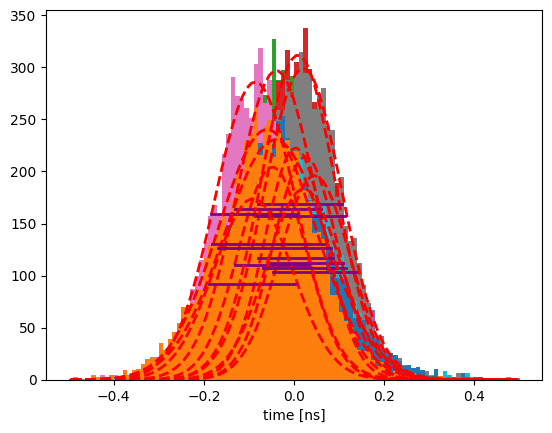

Processing p=1, ch=2...
2/2 [==============================] - 0s 49ms/step
       CFD: 75.42 ps
      UNet: 70.50 ps (improvement: 6.51 %)
Processing p=1, ch=11...
4/4 [==============================] - 0s 75ms/step
       CFD: 87.28 ps
      UNet: 83.54 ps (improvement: 4.29 %)
Processing p=2, ch=2...
2/2 [==============================] - 0s 116ms/step
       CFD: 78.14 ps
      UNet: 71.79 ps (improvement: 8.13 %)
Processing p=2, ch=11...
4/4 [==============================] - 0s 94ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 89.47 ps
      UNet: 83.65 ps (improvement: 6.51 %)
Processing p=3, ch=2...
2/2 [==============================] - 0s 54ms/step
       CFD: 87.37 ps
      UNet: 80.74 ps (improvement: 7.60 %)
Processing p=3, ch=11...
4/4 [==============================] - 0s 70ms/step
       CFD: 112.05 ps
      UNet: 104.40 ps (improvement: 6.82 %)


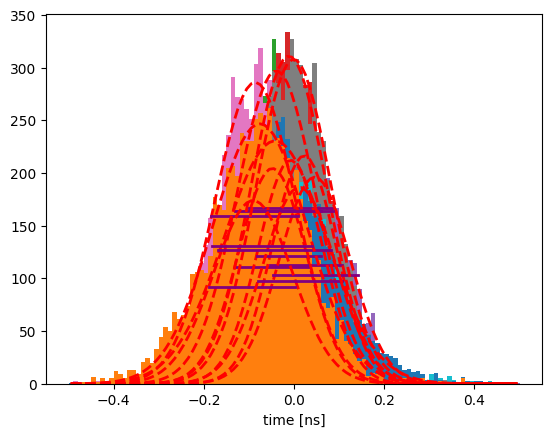

Processing p=1, ch=2...
2/2 [==============================] - 0s 88ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 75.42 ps
      UNet: 73.88 ps (improvement: 2.03 %)
Processing p=1, ch=11...
4/4 [==============================] - 0s 12ms/step
       CFD: 87.28 ps
      UNet: 99.33 ps (improvement: -13.80 %)
Processing p=2, ch=2...
2/2 [==============================] - 0s 100ms/step
       CFD: 78.14 ps
      UNet: 81.72 ps (improvement: -4.58 %)
Processing p=2, ch=11...
4/4 [==============================] - 0s 52ms/step
       CFD: 89.47 ps
      UNet: 90.04 ps (improvement: -0.64 %)
Processing p=3, ch=2...
2/2 [==============================] - 0s 135ms/step
       CFD: 87.37 ps
      UNet: 78.64 ps (improvement: 9.99 %)
Processing p=3, ch=11...
4/4 [==============================] - 0s 91ms/step
       CFD: 112.05 ps
      UNet: 127.88 ps (improvement: -14.13 %)


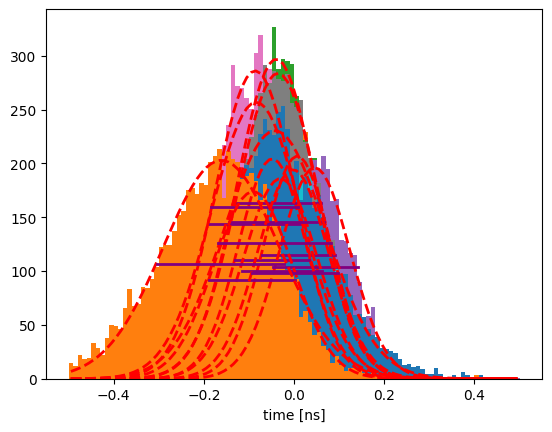

Processing p=1, ch=2...
2/2 [==============================] - 0s 49ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 75.42 ps
      UNet: 87.97 ps (improvement: -16.65 %)
Processing p=1, ch=11...
4/4 [==============================] - 0s 96ms/step
       CFD: 87.28 ps
      UNet: 92.66 ps (improvement: -6.17 %)
Processing p=2, ch=2...
2/2 [==============================] - 0s 121ms/step
       CFD: 78.14 ps
      UNet: 75.74 ps (improvement: 3.07 %)
Processing p=2, ch=11...
4/4 [==============================] - 0s 13ms/step
       CFD: 89.47 ps
      UNet: 90.17 ps (improvement: -0.78 %)
Processing p=3, ch=2...
2/2 [==============================] - 0s 113ms/step
       CFD: 87.37 ps
      UNet: 87.02 ps (improvement: 0.40 %)
Processing p=3, ch=11...
4/4 [==============================] - 0s 50ms/step
       CFD: 112.05 ps
      UNet: 90.32 ps (improvement: 19.39 %)


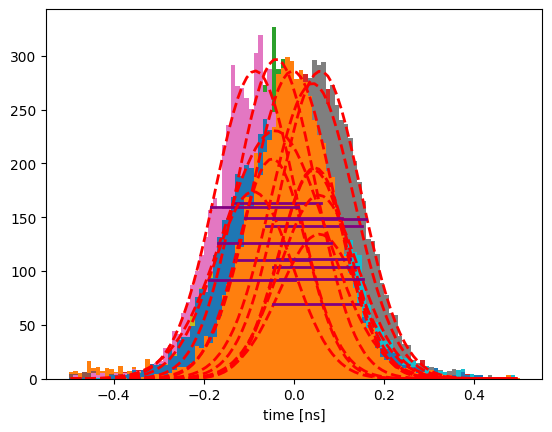

In [16]:
results = {}
for model_plane, model_channel in list(dataset.keys()):
    display(HTML(f'<h3>Loading model p={model_plane}, ch={model_channel}...</h3>'))
    model = create_model()
    load_model(model, f'{model_name}_{model_plane}_{model_channel}')

    this_results = {}
    for (plane, channel), (all_X, all_y) in dataset.items():
        print(f'Processing p={plane}, ch={channel}...')
        _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

        cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
        y_pred_cfd = cfd.predict(x_time, X_test)
        std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

        y_pred_model = model_predict(model, X_test)
        std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

        compare_results([std_model], [model_name], std_cfd)
        this_results[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd) # cfd, model, improv

    plt.show()
    results[(model_plane, model_channel)] = this_results

# Analyse results

In [17]:
# Check that the order is the same
assert list(results.keys()) == sorted(results.keys())
for x in results.values():
    assert list(x.keys()) == sorted(x.keys())

row_names = [str(key) for key in results.keys()]
col_names = [str(key) for key in list(results.values())[0].keys()]

In [18]:
improv_data = np.array([list(str(f'{x[2] * 100:0.2f} %') for x in r.values()) for r in results.values()])

In [19]:
df = pd.DataFrame(improv_data, index=row_names, columns=col_names)
df.index.name = 'trained on / tested on'
df

,"(1, 2)","(1, 11)","(2, 2)","(2, 11)","(3, 2)","(3, 11)"
trained on / tested on,,,,,,
"(1, 2)",8.98 %,3.43 %,8.25 %,-1.64 %,4.72 %,-43.01 %
"(1, 11)",6.84 %,8.97 %,9.32 %,5.80 %,-0.52 %,-38.13 %
"(2, 2)",5.12 %,4.77 %,12.56 %,3.82 %,6.08 %,3.77 %
"(2, 11)",6.51 %,4.29 %,8.13 %,6.51 %,7.60 %,6.82 %
"(3, 2)",2.03 %,-13.80 %,-4.58 %,-0.64 %,9.99 %,-14.13 %
"(3, 11)",-16.65 %,-6.17 %,3.07 %,-0.78 %,0.40 %,19.39 %
